In [11]:
import torch
from torch import nn
from torchmetrics import F1Score
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import ipaddress

# Botnet Detection
## A Multiclass Classification Problem

### About The Dataset

The dataset can be found [zenodo.org/records/8035724](https://zenodo.org/records/8035724)

In the research paper [An empirical comparison of botnet detection methods](https://doi.org/10.1016/j.cose.2014.05.011) we have some information on the features used.
1. Source IP address
2. Amount of unique source ports used by this source IP address.
3. Amount of unique destination IP addresses contacted by this source IP address.
4. Amount of unique destination ports contacted by this source IP address.
5. Amount of NetFlows used by this source IP address.
6. Amount of bytes transferred by this source IP address.
7. Amount of packets transferred by this source IP address.

After clustering some of this observations, the authors created some more features:
1. Total amount of instances in the cluster.
2. Total amount of NetFlows in the cluster.
3. Amount of source IP addresses.
4. Average amount of unique source ports.
5. Standard Deviation of the amount of unique source ports.
6. Average amount of unique destination IP addresses.
7. Standard Deviation of the amount of unique destination IP addresses.
8. Average amount of unique destination ports.
9. Standard Deviation of the amount of unique destination ports.
10. Average amount of NetFlows.
11. Standard Deviation of the amount of NetFlows.
12. Average amount of bytes transferred.
13. Standard Deviation of the amount of bytes transferred.
14. Average amount of packets transferred.
15. Standard Deviation of the amount of packets transferred.

The remaining features should be self-explanatory.

### Importing Data

In [3]:
raw_data = pd.read_csv("./data/botnet_multiclass.csv")

In [6]:
raw_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176640 entries, 0 to 176639
Columns: 85 entries, Unnamed: 0.1 to LABEL
dtypes: bool(4), float64(61), int64(17), object(3)
memory usage: 109.8+ MB


In [8]:
(raw_data.isna()).any().any() # True means that we have missing data

True

We need to transform the object columns, and deal with missing data.

### Preprocessing The Data

In [13]:
preprocessed_data = raw_data.copy(deep=True) 
# since we have enough memory, it should be ok. This will avoid messing the original data.


In [14]:
object_columns = preprocessed_data.select_dtypes(include=['object'])
object_columns.columns


Index(['DST_IP', 'SRC_IP', 'LABEL'], dtype='object')

Let's encode the destination and source IP.

In [17]:
object_columns[['DST_IP', 'SRC_IP']].head()
# notice row with index 3. There's an extra final "."

,DST_IP,SRC_IP
0,147.32.80.9,147.32.84.165
1,147.32.84.255,147.32.84.165
2,147.32.84.255,147.32.84.165
3,147.32.84.165.,60.190.222.139
4,60.190.222.139.,147.32.84.165


In [18]:
def ip_encoding(ip_address:str) -> int:
    return int(ipaddress.ip_address(ip_address.rstrip(".")))

In [22]:
ipaddress.ip_address(ip_encoding("147.32.84.165."))

IPv4Address('147.32.84.165')

In [23]:
preprocessed_data['DST_IP'] = preprocessed_data['DST_IP'].apply(ip_encoding)
preprocessed_data["SRC_IP"] = preprocessed_data['SRC_IP'].apply(ip_encoding)
preprocessed_data[['DST_IP',"SRC_IP"]].head()

,DST_IP,SRC_IP
0,2468368393,2468369573
1,2468369663,2468369573
2,2468369663,2468369573
3,2468369573,1019141771
4,1019141771,2468369573


In [24]:
label_enc = LabelEncoder()
preprocessed_data["LABEL"] = label_enc.fit_transform(preprocessed_data["LABEL"])

In [31]:
label_enc.classes_

array(['clear', 'donbot', 'fast_flux', 'neris', 'qvod', 'rbot'],
      dtype=object)

The zero class represents 'normalware', whereas all the remaining classes represent some sort of malware, more specifically botnets.

Let's do a small EDA on the classes.

In [29]:
labels_counts = preprocessed_data[["LABEL"]].value_counts()
labels_counts

LABEL
0        165573
3          6332
2          4367
4           286
5            55
1            27
Name: count, dtype: int64

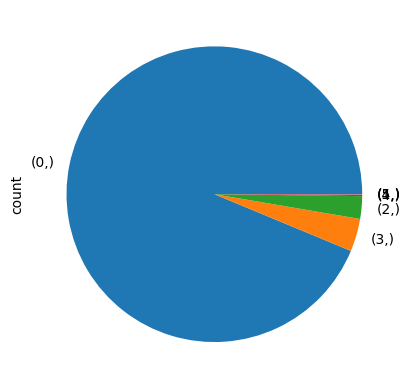

In [32]:
labels_counts.plot.pie(); # type: ignore

Our dataset is highly imbalanced, to the point that classifying some classes could be considered as outlier detection. There will be a section focused on this problem later on.

For now, we will conduct our analysis without worrying to much on the class imbalance problem.

In [37]:
preprocessed_data[preprocessed_data.isna().any(axis=1)].shape
# there are 150598 row whose values have at least an NaN, leaving us with 
# only 26042 rows which are completely filled. Even though torch NN can take NaNs values, 
# these will contaminate the calculations, resulting in predictions full of NaNs. 

(150598, 85)

To keep this notebook simple, I'll just drop the rows with NaN's values.
In a more demanding setting, we should decide on an imputation method for each feature, *separately*. And depending on the chosen method, we may only apply it after we've splitted the data into train and test set.

In [39]:
preprocessed_data = preprocessed_data.dropna()
preprocessed_data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 26042 entries, 1 to 176607
Columns: 85 entries, Unnamed: 0.1 to LABEL
dtypes: bool(4), float64(61), int64(20)
memory usage: 16.4 MB


### Splitting The Data

In [88]:
# Separating features and label
X = torch.tensor(preprocessed_data.iloc[:,:-1].values, dtype=torch.float16)
# float16 uses less memory
y = torch.tensor(preprocessed_data[["Label"]].values, dtype=torch.float16)
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([3571, 241]),
 torch.Size([3571, 1]),
 torch.Size([893, 241]),
 torch.Size([893, 1]))

### Creating The Model

In [80]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [100]:
# 1. Construct a model class that subclasses nn.Module
class BotNetClassifier(nn.Module):
    def __init__(self, bce_loss_with_logits:bool = True):
        super().__init__()
        self.train_loss_values = []
        self.test_loss_values = []
        self.bce_loss_with_logits = bce_loss_with_logits
        self.f1 = F1Score(task="binary", num_classes=2)
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=241, out_features=5, dtype=torch.float16) 
        # takes in 241 features (X), produces 5 features
        # since the matrix is very sparse, I wonder if we can compress the information
        self.layer_2 = nn.Linear(in_features=5, out_features=1, dtype=torch.float16)
            # produces 1 feature, since we're in a binary classification problem
        if not bce_loss_with_logits:
            self.layer_3 = nn.Sigmoid(in_features=5, out_features=1)
        

    def forward(self, x):
        return  self.layer_2(self.layer_1(x))
    
    def train_loop(self, input: torch.Tensor, labels: torch.Tensor, 
                   loss_fn:nn.modules.loss._Loss, optimizer: torch.optim.Optimizer):
        self.train()
        # Forward pass on train data using the forward() method
        if self.bce_loss_with_logits:
            # bce_loss_with_logits works directly with logits
            pred = self(input)
        else:
            pred = torch.round(self(input)) 
        loss = loss_fn(pred, labels)
        f1_value = self.f1(pred, labels)
        # Backpropagation
        loss.backward()
        # optimize parameters
        optimizer.step()
        # restart cycle
        optimizer.zero_grad()
        return loss, f1_value
    
    def test_loop(self, input: torch.Tensor, labels: torch.Tensor, 
                  loss_fn:nn.modules.loss._Loss):
        self.eval()
        with torch.inference_mode():
            pred = self(input)
            loss = loss_fn(pred, labels)
            f1_value = self.f1(pred, labels)
        return loss, f1_value
    
    def train_model(self, input: torch.Tensor, labels: torch.Tensor,
                    loss_fn:nn.modules.loss._Loss, optimizer: torch.optim.Optimizer,
                    n_epochs:int = 100):
        for epoch in range(1,n_epochs+1):
            print(f"Epoch {epoch}\n-------------------------------")
            train_loss, train_f1 = self.train_loop(input = input, labels = labels, 
                                         loss_fn = loss_fn, optimizer = optimizer)
            self.train_loss_values.append(train_loss.detach().cpu().numpy())
            test_loss, test_f1 = self.test_loop(input = input, labels = labels, 
                                       loss_fn = loss_fn)
            self.test_loss_values.append(test_loss.detach().cpu().numpy())
            print(
                f"{loss_fn._get_name()} Train Loss: {train_loss} |"
                f"{loss_fn._get_name()} Test Loss: {test_loss}"
            )
            print(
                f"F1 Train Score: {train_f1}  | F1 Test Score: {test_f1}"
            )
        print("Done!")
    
    def predict(self, input: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.inference_mode():
            pred = self(input)
        return pred

In [101]:
# 4. Create an instance of the model and send it to target device
linear_cl = BotNetClassifier().to(device)
linear_cl

MalwareLinearClassifier(
  (f1): BinaryF1Score()
  (layer_1): Linear(in_features=241, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [102]:
linear_cl(X_train.to(device)) # simple litmus test to check whether it's working

tensor([[-0.2734],
        [-0.2812],
        [-0.2986],
        ...,
        [-0.3066],
        [-0.3188],
        [-0.3511]], device='cuda:0', dtype=torch.float16,
       grad_fn=<AddmmBackward0>)

In [103]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=linear_cl.parameters(), 
                            lr=0.1)


In [104]:
linear_cl.train_model(input= X_train.to(device), labels=y_train.to(device), 
                      loss_fn=loss_fn, optimizer=optimizer)

Epoch 1
-------------------------------
BCEWithLogitsLoss Train Loss: 0.8291015625 |BCEWithLogitsLoss Test Loss: 0.71533203125
F1 Train Score: 0.0  | F1 Test Score: 0.3769735097885132
Epoch 2
-------------------------------
BCEWithLogitsLoss Train Loss: 0.71533203125 |BCEWithLogitsLoss Test Loss: 0.62548828125
F1 Train Score: 0.3769735097885132  | F1 Test Score: 0.9489138722419739
Epoch 3
-------------------------------
BCEWithLogitsLoss Train Loss: 0.62548828125 |BCEWithLogitsLoss Test Loss: 0.552734375
F1 Train Score: 0.9489138722419739  | F1 Test Score: 0.9493876099586487
Epoch 4
-------------------------------
BCEWithLogitsLoss Train Loss: 0.552734375 |BCEWithLogitsLoss Test Loss: 0.49365234375
F1 Train Score: 0.9493876099586487  | F1 Test Score: 0.9497058987617493
Epoch 5
-------------------------------
BCEWithLogitsLoss Train Loss: 0.49365234375 |BCEWithLogitsLoss Test Loss: 0.4462890625
F1 Train Score: 0.9497058987617493  | F1 Test Score: 0.9497058987617493
Epoch 6
-------------

An F1 of +99%, with such a simple model seems too good to be true...
There could be some sort of label data leakage in the dataset, specially if we look at the test and train F1 score and notice that they are equal. This is highly suspicious.

# Credit Score Brackets
## A MultiClass Problem


The dataset can be found [here](https://www.kaggle.com/datasets/sudhanshu2198/processed-data-credit-score)